In [810]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import nbinom, fit
import math

In [811]:
df = pd.read_csv('inventory.csv')
df['Date']  = pd.to_datetime(df['Day'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Holiday'] = df['Month'].apply(lambda x: True if x == 11 or x == 12 else False )


In [812]:
df.head()

,Day,Demand,Inventory,Date,Month,Year,Holiday
0,1,340,4660,2019-01-01,1,2019,False
1,2,336,4324,2019-01-02,1,2019,False
2,3,177,4147,2019-01-03,1,2019,False
3,4,172,3975,2019-01-04,1,2019,False
4,5,513,3462,2019-01-05,1,2019,False


In [813]:
df.loc[:,"Demand":"Inventory"].describe()

,Demand,Inventory
count,1096.000000,1096.000000
mean,271.187956,11319.837591
std,110.991922,3672.812563
min,44.000000,881.000000
25%,190.000000,8678.500000
50%,253.500000,11441.500000
75%,339.250000,13879.750000
max,709.000000,19660.000000


<Axes: xlabel='Date'>

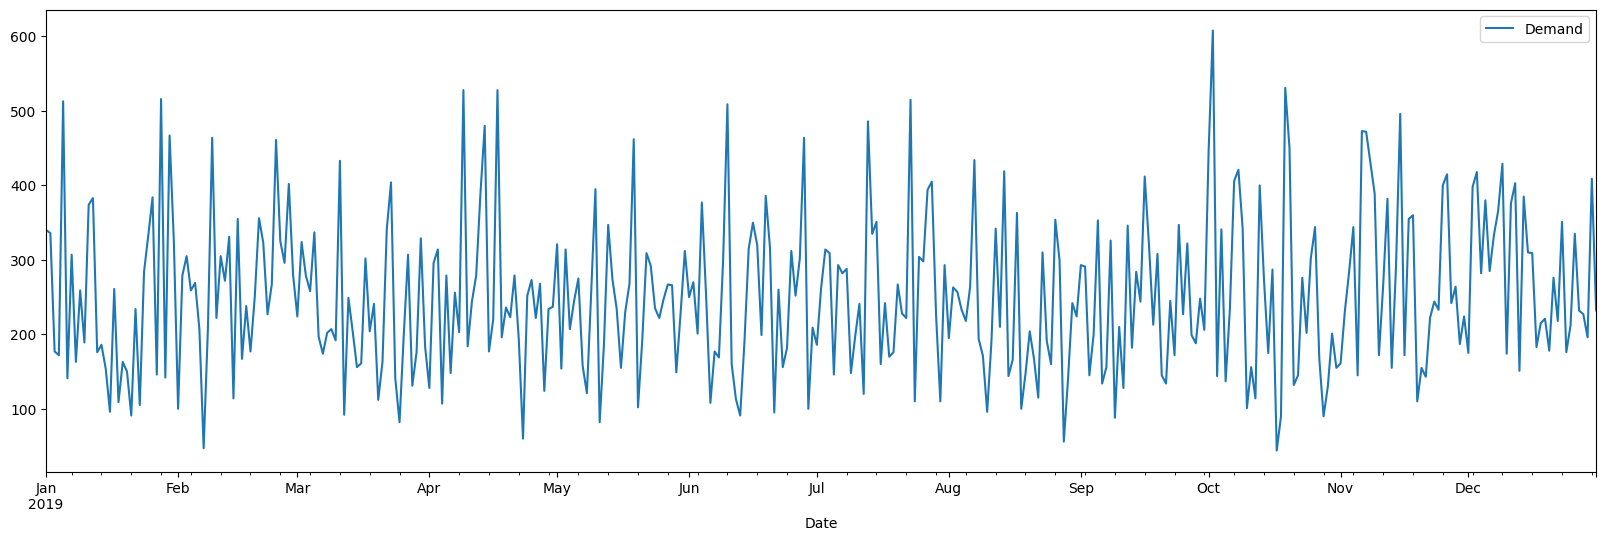

In [814]:
df.iloc[:365].plot(x = "Date", y = "Demand", figsize=(20, 6))

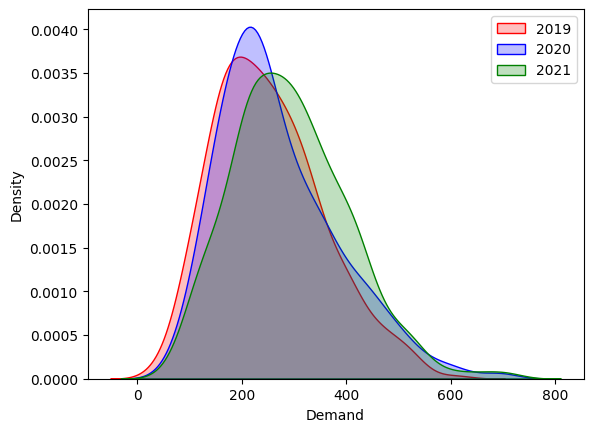

In [815]:
# sns.displot(df.iloc[:365].Demand, kde = True, bins =50)
# sns.displot(df.iloc[366:731].Demand, kde = True, bins =50)

sns.kdeplot(data=df[df["Year"] == 2019], x='Demand', fill=True, 
            color="red", label="2019")
sns.kdeplot(data=df[df["Year"] == 2020], x='Demand', fill=True, 
            color="blue", label="2020")
sns.kdeplot(data=df[df["Year"] == 2021], x='Demand', fill=True, 
            color="green", label="2021")
plt.legend()
plt.show()

<Figure size 2000x600 with 0 Axes>

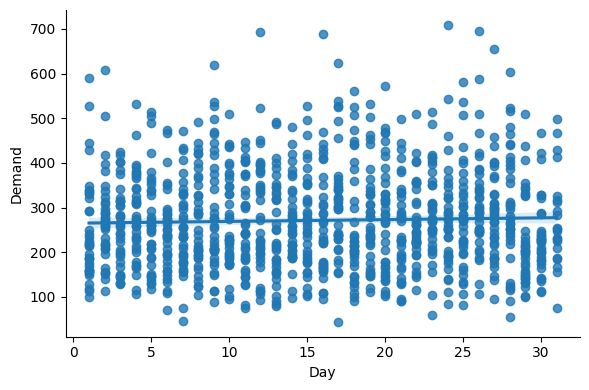

In [816]:
plt.figure(figsize=(20, 6))
sns.lmplot(x="Day", y="Demand", data=df,height=4, aspect=1.5)
plt.show()

## Check if it is negative binomial

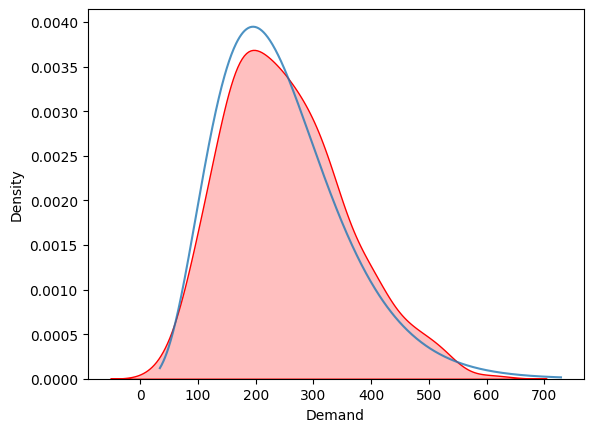

In [817]:
r = 5
p = 0.02

# Create an array of possible values for the distribution
x = np.arange(nbinom.ppf(0.001, r, p), nbinom.ppf(0.999, r, p))

# Calculate the probability mass function (PMF) of the distribution
pmf = nbinom.pmf(x, r, p)

# Plot the PMF of the negative binomial distribution
fig, ax = plt.subplots()
ax.plot(x, pmf, ms=8, alpha=0.8)

sns.kdeplot(data=df[df["Year"] == 2019], x='Demand', fill=True, 
            color="red", label="2019")

# ax.vlines(x, 0, pmf, colors='b', lw=5, alpha=0.5)
# ax.set_title('Negative Binomial Distribution (r=5, p=0.5)')
# ax.set_xlabel('Number of Failures Before Success')
# ax.set_ylabel('Probability Mass Function')
plt.show()


## Q2: Inventory Policy

<Axes: xlabel='Date'>

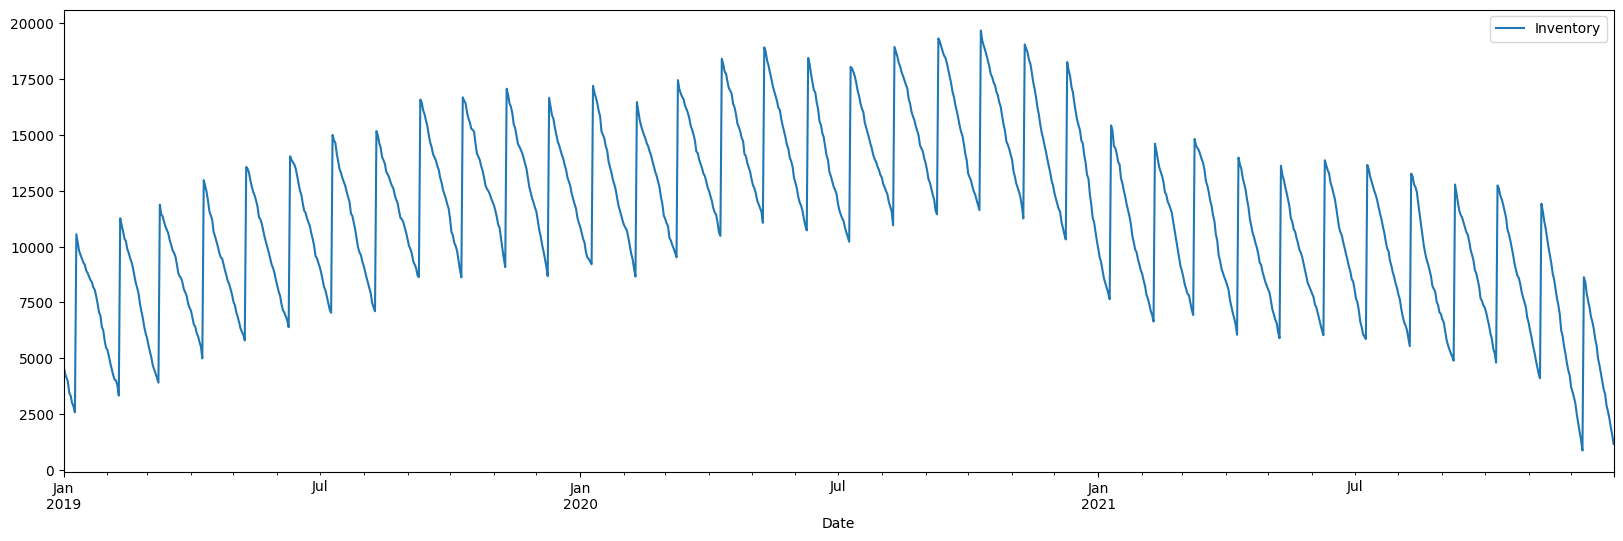

In [818]:
df.plot(x = "Date", y = "Inventory",figsize = (20,6))

In [819]:
## Find out the difference of Inventory from t to t+1 
df['Diff'] = df.Inventory.diff()
# Find which day does the replenishment happened
print("replenishment date: " + str((df[df['Diff'] > 0]['Day'].unique())[0]))
# add back demand
print("replenishment amount: " + str( ((df[df['Diff'] > 0]["Diff"] + df[df['Diff'] > 0]["Demand"]).unique())[0]))

replenishment date: 10
replenishment amount: 8150.0


Inventory beginning of the Jan 1, 2019: 5,000 units

## Q3: Cost of 2022

#### Constants

In [820]:
# constants
holding_cost_per_unit = 0.25
set_up_cost = 1200
production_cost_per_unit = 1.5
unit_margin = 35.5
holiday_demand_inc = 70
yearly_demand_inc = 10

# Beginning inventory of 2022-01-01
begin_inv_2022 = df.iloc[-1]['Inventory']

# Average Replenishment Amount for 2022
replenishment_amount = 8150.0

#### Demand generation using Binomial Distribution

In [821]:
np.random.seed(67)
r = 5
p = 0.02
size = 365
new_demand = nbinom.rvs(r, p, size=size) + 3 * yearly_demand_inc
df_2022 = pd.DataFrame(new_demand, columns = ['Demand'])
dates = pd.date_range(start='2022-01-01', periods=len(df_2022), freq='D')
df_2022['Date'] = dates
df_2022['Day'] = df_2022['Date'].dt.day
df_2022['Month'] = df_2022['Date'].dt.month
df_2022['Year'] = df_2022['Date'].dt.year
df_2022['Holiday'] = df_2022['Month'].apply(lambda x: True if x == 11 or x == 12 else False )

# Add 70 to demand for holiday seasons
df_2022.iloc[-61:,0] += holiday_demand_inc
df_2022.head()

,Demand,Date,Day,Month,Year,Holiday
0,391,2022-01-01,1,1,2022,False
1,285,2022-01-02,2,1,2022,False
2,289,2022-01-03,3,1,2022,False
3,399,2022-01-04,4,1,2022,False
4,149,2022-01-05,5,1,2022,False


#### Calculate change in inventory based on demand generated and current policy used by the company (order on every 1st day of the month with 8150 units) 

In [1077]:
for index, row in df_2022.iterrows():
    
    if index == 0:
        pre_inventory = begin_inv_2022

    # add replenishiment
    if row['Day'] == 10:
        pre_inventory = pre_inventory + replenishment_amount

    if pre_inventory - row['Demand'] < 0:
        df_2022.loc[index, "Demand_Fulfilled"] = pre_inventory
        df_2022.loc[index, "Demand_Unfulfilled"] = row['Demand'] - pre_inventory
        pre_inventory = 0 
    else:
        df_2022.loc[index, "Demand_Fulfilled"] = row['Demand']
        pre_inventory = pre_inventory - row['Demand']
        df_2022.loc[index, "Demand_Unfulfilled"] = 0

    df_2022.loc[index,"Inventory"] = pre_inventory

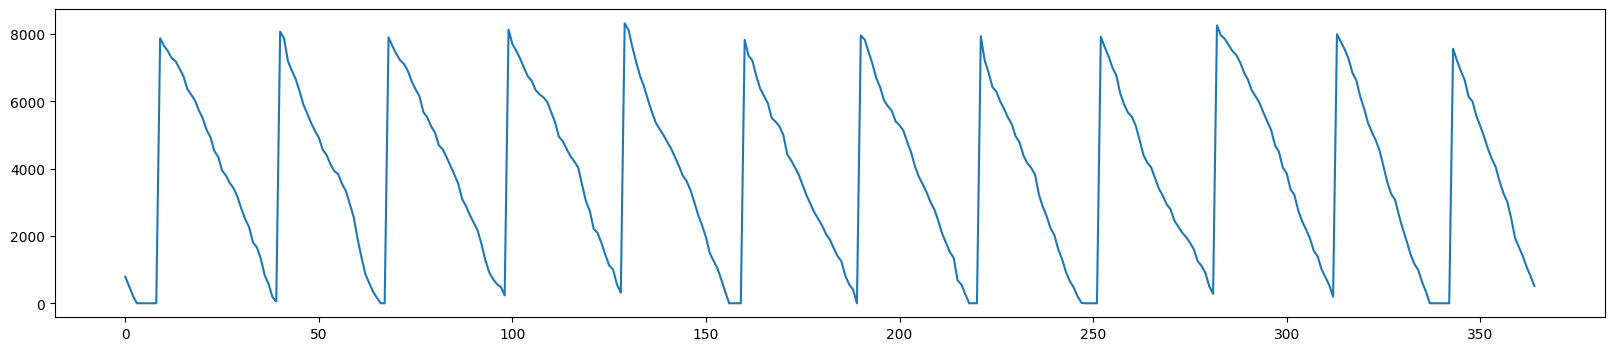

In [1078]:
plt.figure(figsize=(20, 4))
plt.plot(df_2022['Inventory'])
plt.show()

In [1080]:
df_2022.head(20)

,Demand,Date,Day,Month,Year,Holiday,Demand_Fulfilled,Inventory,Demand_Unfulfilled
0,391,2022-01-01,1,1,2022,False,391.0,787.0,0.0
1,285,2022-01-02,2,1,2022,False,285.0,502.0,0.0
2,289,2022-01-03,3,1,2022,False,289.0,213.0,0.0
3,399,2022-01-04,4,1,2022,False,213.0,0.0,186.0
4,149,2022-01-05,5,1,2022,False,0.0,0.0,149.0
5,115,2022-01-06,6,1,2022,False,0.0,0.0,115.0
6,510,2022-01-07,7,1,2022,False,0.0,0.0,510.0
7,326,2022-01-08,8,1,2022,False,0.0,0.0,326.0
8,332,2022-01-09,9,1,2022,False,0.0,0.0,332.0
9,274,2022-01-10,10,1,2022,False,274.0,7876.0,0.0


#### Calculate Profit and Loss

In [1081]:
total_holding_c = holding_cost_per_unit * df_2022.Inventory.sum()
total_set_up_c =  set_up_cost * 12 
total_production_c = (production_cost_per_unit * replenishment_amount) * 12
total_revenue = unit_margin * df_2022["Demand_Fulfilled"].sum()
total_cost = total_holding_c + total_set_up_c  + total_production_c
total_profit = total_revenue - total_cost
underage_cost = df_2022["Demand_Unfulfilled"].sum() * unit_margin
economic_profit = total_profit - underage_cost
data = {"total_holding_c": total_holding_c,
        "total_setup_c": total_set_up_c,
        "total_production_c": total_production_c,
        "total_revenue": total_revenue,
        "total_cost": total_cost,
        "profit": total_profit,
        "underage_cost": underage_cost,
        "economic_profit": economic_profit
        }
p_l_2022_old = pd.DataFrame(data, index = [2022])
p_l_2022_old

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
2022,349154.0,14400,146700.0,3495436.5,510254.0,2985182.5,220348.5,2764834.0


## Q4

#### Profit and Loss for year 2019~2021 (Old)

In [541]:
replenishment_amount = 8150.0

In [1088]:
# Revenue
revenue = df.groupby(["Year"])['Demand'].sum() * unit_margin 
# Holding cost
holding_cost = df.groupby(["Year"])["Inventory"].sum() * holding_cost_per_unit

profit_loss_old =  pd.concat([holding_cost,revenue] , axis= 1, keys=[ "total_holding_c","total_revenue"])

# Production Cost
profit_loss_old['total_production_c']  = replenishment_amount * production_cost_per_unit * 12
# Holding cost
profit_loss_old['total_setup_c'] = set_up_cost * 12

profit_loss_old['total_cost'] = profit_loss_old["total_holding_c"] + profit_loss_old["total_production_c"] + profit_loss_old['total_setup_c']
profit_loss_old['profit'] = profit_loss_old["total_revenue"] - profit_loss_old['total_cost']
profit_loss_old['underage_cost'] = 0
profit_loss_old["economic_profit"]= profit_loss_old['underage_cost']  + profit_loss_old['profit']
profit_loss_old = profit_loss_old[["total_holding_c","total_setup_c", "total_production_c", "total_revenue", "total_cost", "profit","underage_cost","economic_profit"]].copy()
profit_loss_old

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
Year,,,,,,,,
2019,956871.25,14400,146700.0,3256841.0,1117971.25,2138869.75,0,2138869.75
2020,1313014.25,14400,146700.0,3501152.0,1474114.25,2027037.75,0,2027037.75
2021,831750.00,14400,146700.0,3793388.0,992850.00,2800538.00,0,2800538.00


#### Profit and Loss for year 2019~2021 (New Model: EOQ + Reorder Point )

In [961]:
begin_inv_2019 = 5000

Based on EOQ the optimal solution Q should be $\sqrt{ \frac{2 * E[D] * S}{ H}}$

Suppose 𝑋,𝑌
 are independent random variables with 𝑋∼𝑁𝐵(𝑟,𝑝)
 and 𝑌∼𝑁𝐵(𝑠,𝑝)
. Then
𝑋+𝑌∼𝑁𝐵(𝑟+𝑠,𝑝)

In [962]:
holding_cost_per_unit = 0.25
set_up_cost = 1200
production_cost_per_unit = 1.5
unit_margin = 35.5
holiday_demand_inc = 70
yearly_demand_inc = 10
lead_time = 8 

#### Optimal Quantity EOQ and ROP for 2019 ~ 2021

If X ~ NB(r,p) \
E[X] = rq / p, where q = 1 – p. \
var[X] is rq / p^2


In [ ]:
X ~ NB(5, 0.02) + NB(5, 0.02)= NB(5+5, 0.02) = NB(10, 0.02)
E[X] = rq/p = 5(1-0.02) / 0.02

In [1041]:
# EOQ Generator; returns a data frame
# cycle: yearly, monthly
def EOQ_generator(df, cycle, holding_cost, set_up_cost):
    # find optimal quantity of order based on the mean of year demand 
    if cycle == "yearly":
        cycle = ["Year"]
    elif cycle == "monthly":
        cycle = ["Year","Month"]
    num_days_cycle = df.groupby(cycle)['Date'].count()
    EOQ = np.ceil(np.sqrt( 2 * ( df.groupby(cycle)['Demand'].sum() ) * set_up_cost / (holding_cost * num_days_cycle))).to_frame("optimal_q")
    return EOQ


# ROP Generator 
def ROP_generator(df, cycle, risk_level = 0.05, lead_time = 8):
    if cycle == "yearly":
        cycle = ["Year"]
    elif cycle == "monthly":
        cycle = ["Year","Month"]
    if risk_level == 0:
        risk_level = 0.0000001
    if risk_level == 1:
        risk_level = 0.9999999
    # calculate mean and variance of the demand over the year
    mean_demand = df.groupby(cycle)["Demand"].mean() 
    var_demand = df.groupby(cycle)["Demand"].var()
    ## calculate parameters of negative binomial distribution based on actual mean and variance
    r_new = mean_demand ** 2 / (var_demand - mean_demand)
    p_new = r_new / (r_new + mean_demand)
    ROP = pd.concat([mean_demand, var_demand, r_new, p_new] , axis= 1,keys=["mean_demand", "var_demand", "r_new", "p_new"] )
    ROP["ROP+ss"] = ROP.apply(lambda row: nbinom.ppf(1 - risk_level, row["r_new"] * lead_time, row["p_new"]), axis = 1)
    return ROP[["ROP+ss"]]

In [1082]:
# Calculate new inventory for each day based on new replenishment 
def new_inv_calculator(df_input, cycle, holding_cost, set_up_cost, begin_inv, risk_level = 0.05, lead_time = 8, order_gap = 8):

    df = df_input.copy()
    
    ## to track number of orders we placed in each year
    num_orders = pd.DataFrame({"Num_Orders": np.zeros(len(df["Year"].unique()))}, index=df["Year"].unique())

    ## indicators for reorder point trigger
    delivery_day = np.array([])
    days_cannot_place_order = 0

    EOQ_df = EOQ_generator(df, cycle, holding_cost, set_up_cost).copy()
    ROP_df = ROP_generator(df, cycle, risk_level, lead_time).copy()
    

    ## Set EOQ and ROP base on Year, for monthly cycle, preset the EOQ and ROP of last 10 days of the current month to next month's EOQ and ROP (except for December)
    for index, row in df.iterrows():
        if cycle == "yearly":
            cycle_ind = row["Year"]
        else:
            if (row['Day'] > 20) & (row["Month"] < 12):
                cycle_ind = (row["Year"],row["Month"] + 1)
            else: 
                cycle_ind = (row["Year"],row["Month"])
        EOP = EOQ_df.loc[cycle_ind, "optimal_q"]
        ROP = ROP_df.loc[cycle_ind, "ROP+ss"]
        if index == 0:
                pre_inventory = begin_inv 
        
        # check if we can place a order
        if days_cannot_place_order == 0:
            # check if inventory lower than ROP
            if (pre_inventory - row["Demand"]) <= ROP_df.loc[cycle_ind, "ROP+ss"]:
                # add a new order to our order list
                delivery_day = np.append(delivery_day,0)
                # can't place an order after 5 days
                days_cannot_place_order = order_gap
        else:
            days_cannot_place_order -= 1

        df.loc[index,"Order_Quantity"] = 0

        if delivery_day.size >= 1:
            if delivery_day[0] == lead_time + 1:
                # add EOQ to inventory 
                pre_inventory += EOQ_df.loc[cycle_ind, "optimal_q"]
                df.loc[index,"Order_Quantity"] =  EOQ_df.loc[cycle_ind, "optimal_q"]
                # delete the order from the order list 
                delivery_day = np.delete(delivery_day,0)
                num_orders.loc[row["Year"],"Num_Orders"] += 1
            delivery_day += 1
            
        if pre_inventory < row['Demand']:
                df.loc[index, "Demand_Fulfilled"] = pre_inventory
                df.loc[index, "Demand_Unfulfilled"] = row['Demand'] - pre_inventory
                pre_inventory = 0
        else:
            df.loc[index, "Demand_Fulfilled"] = row['Demand']
            pre_inventory = pre_inventory - row['Demand']
            df.loc[index, "Demand_Unfulfilled"] = 0
            
        df.loc[index,"New_Inventory"] = pre_inventory
    return df, num_orders

In [1085]:
# Calculate the profit and loss based on the new inventory and demand satsified using ROP and EOQ
def p_l_calculator(df_input, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = 0.05, lead_time = 8, order_gap = 8):
    
    df, num_orders = new_inv_calculator(df_input, cycle, holding_cost_per_unit, set_up_cost, begin_inv, risk_level, lead_time, order_gap)

    total_holding_c = holding_cost_per_unit * df.groupby(["Year"])["New_Inventory"].sum()
    total_setup_c = set_up_cost * num_orders
    
    df.groupby("Year")["Order_Quantity"].sum()
    order_q = df.groupby("Year")["Order_Quantity"].sum()
    total_production_c = (production_cost_per_unit * order_q).to_frame().rename(columns = {"Order_Quantity" : "Production"})

    total_revenue = unit_margin * df.groupby(["Year"])["Demand_Fulfilled"].sum()
    total_cost = total_holding_c + total_setup_c + total_production_c
    
    profit_loss_new = pd.concat([total_holding_c,total_setup_c,total_production_c, total_revenue] , axis= 1)\
            .rename(columns = {"New_Inventory":"total_holding_c","Num_Orders":  "total_setup_c", "Production": "total_production_c", "Demand_Fulfilled":"total_revenue"})
    profit_loss_new

    profit_loss_new["total_cost"] = profit_loss_new["total_production_c"] + profit_loss_new["total_setup_c"] + profit_loss_new["total_holding_c"]
    profit_loss_new["profit"] = profit_loss_new["total_revenue"] - profit_loss_new["total_cost"]

    profit_loss_new["underage_cost"] = df.groupby(["Year"])["Demand_Unfulfilled"].sum() * unit_margin
    profit_loss_new["economic_profit"] = profit_loss_new["profit"] - profit_loss_new["underage_cost"]
    
    return profit_loss_new


In [1092]:
## calcualtes the difference of old and new metrics in percentage (new - old)/new
def p_l_diff_calculator(df_pl_old, df_pl_new):
    p_l_diff_per = pd.DataFrame( data = np.round(((df_pl_new.values - df_pl_old.values) / df_pl_new.values) * 100,2),  
                                columns = ["holding_cost", "setup_cost", "production_cost", "revenue", "total_cost", "profit","underage_cost","economic_profit"], 
                                index = df_pl_old.index)

    p_l_diff_per["new_profit_margin"]= df_pl_new["profit"]/ df_pl_new["total_revenue"] * 100
    p_l_diff_per["old_profit_margin"] = df_pl_old["profit"]/ df_pl_old["total_revenue"] * 100
    p_l_diff_per["diff_profit_margin"] = p_l_diff_per["new_profit_margin"] - p_l_diff_per["old_profit_margin"]
    return p_l_diff_per


In [1100]:
holding_cost = 0.25
set_up_cost = 1200
production_cost_per_unit = 1.5
unit_margin = 35.5
begin_inv = 5000
cycle = "yearly"
df_EOQ_2019_2021 = df[["Day","Demand","Inventory","Date","Month","Year","Holiday"]].copy()

profit_loss_new = p_l_calculator(df_EOQ_2019_2021, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = 0.05, lead_time = 8, order_gap = 8)
profit_loss_new

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
2019,54528.5,46800.0,90909.0,2319854.0,192237.5,2127616.5,936987.0,1190629.5
2020,42924.0,49200.0,98953.5,2324149.5,191077.5,2133072.0,1177002.5,956069.5
2021,42931.0,48000.0,100620.0,2408249.0,191551.0,2216698.0,1385139.0,831559.0


In [1101]:
profit_loss_old

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
Year,,,,,,,,
2019,956871.25,14400,146700.0,3256841.0,1117971.25,2138869.75,0,2138869.75
2020,1313014.25,14400,146700.0,3501152.0,1474114.25,2027037.75,0,2027037.75
2021,831750.00,14400,146700.0,3793388.0,992850.00,2800538.00,0,2800538.00


In [1102]:
# i.e. holding cost of the new policy in 2019 is 14 times less than the old policy
p_l_diff_calculator(profit_loss_old, profit_loss_new)

,holding_cost,setup_cost,production_cost,revenue,total_cost,profit,underage_cost,economic_profit,new_profit_margin,old_profit_margin,diff_profit_margin
Year,,,,,,,,,,,
2019,-1654.81,69.23,-61.37,-40.39,-481.56,-0.53,100.0,-79.64,91.713379,65.673140,26.040239
2020,-2958.93,70.73,-48.25,-50.64,-671.47,4.97,100.0,-112.02,91.778605,57.896308,33.882297
2021,-1837.41,70.00,-45.80,-57.52,-418.32,-26.34,100.0,-236.78,92.046047,73.826827,18.219220


### Q5

In [1103]:
df_4_years = pd.concat([df[["Day", "Demand", "Year", "Month", "Date"]].copy(), df_2022[["Day", "Demand", "Year", "Month", "Date"]].copy()]).reset_index(drop = True)
df_4_years

,Day,Demand,Year,Month,Date
0,1,340,2019,1,2019-01-01
1,2,336,2019,1,2019-01-02
2,3,177,2019,1,2019-01-03
3,4,172,2019,1,2019-01-04
4,5,513,2019,1,2019-01-05
...,...,...,...,...,...
1456,27,275,2022,12,2022-12-27
1457,28,264,2022,12,2022-12-28
1458,29,327,2022,12,2022-12-29
1459,30,267,2022,12,2022-12-30


In [1104]:
profit_loss_new = p_l_calculator(df_4_years, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = 0.05, lead_time = 8)
profit_loss_new.loc[[2022]]

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
2022,42638.25,49200.0,102090.0,2388759.5,193928.25,2194831.25,1327025.5,867805.75


In [1105]:
p_l_2022_old

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
2022,349154.0,14400,146700.0,3495436.5,510254.0,2985182.5,220348.5,2764834.0


In [1106]:
p_l_diff_calculator(p_l_2022_old, profit_loss_new.loc[[2022]])

,holding_cost,setup_cost,production_cost,revenue,total_cost,profit,underage_cost,economic_profit,new_profit_margin,old_profit_margin,diff_profit_margin
2022,-718.88,70.73,-43.7,-46.33,-163.11,-36.01,83.4,-218.6,91.881634,85.402281,6.479353


## Q6

In [1107]:
def risk_test(risk_level_range, df_4_years, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, lead_time = 8 ):
    for i, risk_level in enumerate(risk_level_range):
        if i == 0:
            pl_df = p_l_calculator(df_4_years, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = risk_level, lead_time = lead_time)
            pl_df["risk_level"] = risk_level
        else:
            pl_df_new = p_l_calculator(df_4_years, "yearly", begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = risk_level, lead_time = lead_time)
            pl_df_new["risk_level"] = risk_level
            pl_df = pd.concat([pl_df, pl_df_new])
    return pl_df


In [1108]:
holding_cost = 0.25
set_up_cost = 1200
production_cost_per_unit = 1.5
unit_margin = 35.5
begin_inv = 5000
lead_time = 8
risk_level_range = np.arange(0,1.1,0.1)

risk_level_range
risk_df = risk_test(risk_level_range, df_4_years, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, lead_time = lead_time)
risk_df.head()

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit,risk_level
2019,58030.25,48000.0,93240.0,2337249.0,199270.25,2137978.75,919592.0,1218386.75,0.0
2020,42456.75,48000.0,96540.0,2331711.0,186996.75,2144714.25,1169441.0,975273.25,0.0
2021,40488.75,49200.0,103135.5,2422165.0,192824.25,2229340.75,1371223.0,858117.75,0.0
2022,40688.25,48000.0,99600.0,2375908.5,188288.25,2187620.25,1339876.5,847743.75,0.0
2019,54341.00,46800.0,90909.0,2311618.0,192050.00,2119568.00,945223.0,1174345.00,0.1


In [986]:
risk_df.loc[2019]

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,risk_level
2019,58030.25,48000.0,93240.0,2337249.0,199270.25,2137978.75,0.0
2019,54341.00,46800.0,90909.0,2311618.0,192050.00,2119568.00,0.1
2019,54341.00,46800.0,90909.0,2311618.0,192050.00,2119568.00,0.2
2019,54341.00,46800.0,90909.0,2311618.0,192050.00,2119568.00,0.3
2019,54341.00,46800.0,90909.0,2311618.0,192050.00,2119568.00,0.4
2019,51690.75,46800.0,90909.0,2303559.5,189399.75,2114159.75,0.5
2019,51690.75,46800.0,90909.0,2303559.5,189399.75,2114159.75,0.6
2019,51690.75,46800.0,90909.0,2303559.5,189399.75,2114159.75,0.7
2019,51690.75,46800.0,90909.0,2303559.5,189399.75,2114159.75,0.8
2019,49863.50,46800.0,90909.0,2296601.5,187572.50,2109029.00,0.9


<Axes: xlabel='risk_level'>

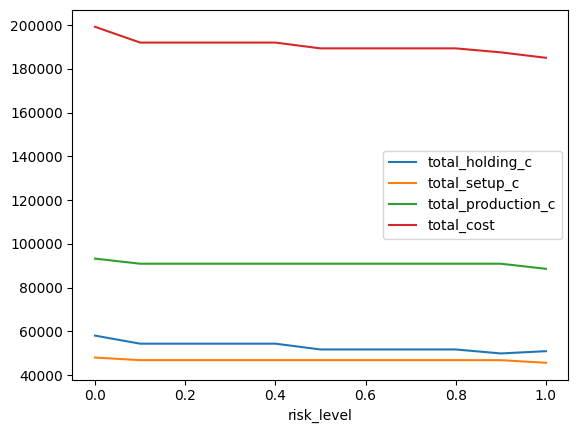

In [1059]:
risk_df.loc[2019].plot(x = "risk_level",  y = ["total_holding_c","total_setup_c","total_production_c","total_cost"], kind = 'line')

<Axes: xlabel='risk_level'>

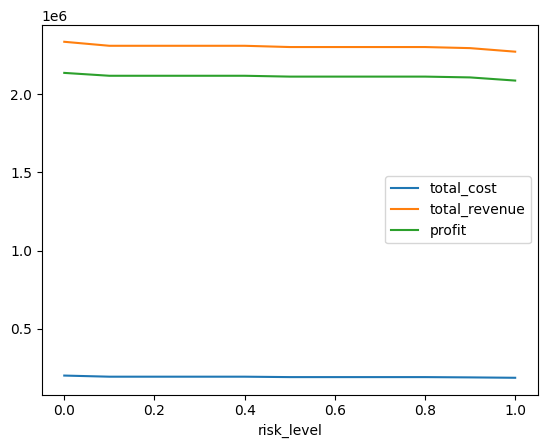

In [988]:
risk_df.loc[2019].plot(x = "risk_level",  y = ["total_cost","total_revenue","profit"], kind = 'line')

## Q7

In [1118]:
holding_cost = 0.25
set_up_cost = 1200
production_cost_per_unit = 1.5
unit_margin = 35.5
begin_inv = 5000
## choose cycle to be "monthly" or "yearly"
cycle = "monthly"
## if order_gap = 8 means we can't order before the order arrives (can't order in 8 days)
order_gap = 5

profit_loss_new = p_l_calculator(df, cycle, begin_inv, holding_cost, set_up_cost, production_cost_per_unit, unit_margin, risk_level = 0.05, lead_time = 8, order_gap =order_gap)
profit_loss_new

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
2019,195426.50,68400.0,133317.0,3256841.0,397143.50,2859697.50,0.0,2859697.50
2020,208978.25,72000.0,145282.5,3501152.0,426260.75,3074891.25,0.0,3074891.25
2021,84774.50,73200.0,153717.0,3636584.5,311691.50,3324893.00,156803.5,3168089.50


In [1111]:
profit_loss_old

,total_holding_c,total_setup_c,total_production_c,total_revenue,total_cost,profit,underage_cost,economic_profit
Year,,,,,,,,
2019,956871.25,14400,146700.0,3256841.0,1117971.25,2138869.75,0,2138869.75
2020,1313014.25,14400,146700.0,3501152.0,1474114.25,2027037.75,0,2027037.75
2021,831750.00,14400,146700.0,3793388.0,992850.00,2800538.00,0,2800538.00


In [1110]:
p_l_diff_calculator(profit_loss_old, profit_loss_new)

/var/folders/lc/b3fnl0s565b49nnwtc7k9r_40000gn/T/ipykernel_56366/22052764.py:3: RuntimeWarning: invalid value encountered in divide
  p_l_diff_per = pd.DataFrame( data = np.round(((df_pl_new.values - df_pl_old.values) / df_pl_new.values) * 100,2),


,holding_cost,setup_cost,production_cost,revenue,total_cost,profit,underage_cost,economic_profit,new_profit_margin,old_profit_margin,diff_profit_margin
Year,,,,,,,,,,,
2019,-320.80,78.95,-10.32,0.00,-160.74,24.37,NaN,24.37,86.834658,65.673140,21.161518
2020,-408.18,80.65,2.65,-0.17,-204.91,32.69,100.0,32.56,86.167564,57.896308,28.271255
2021,-227.03,81.25,9.04,-0.15,-101.63,15.01,100.0,14.87,86.999757,73.826827,13.172930
